In [1]:
import sys
import time
import pickle as pkl

import numpy as np
import pandas as pd

import torch
import torch_geometric

import networkx as nx
from networkx import draw_networkx_nodes, draw_networkx_edges

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
%matplotlib inline
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import awkward as ak
import fastjet
import vector

## Configuration

In [2]:
if torch.cuda.device_count():
    device = torch.device("cuda:0")
else:
    device = "cpu"
    
N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

# JET_ALGO = fastjet.kt_algorithm
# JET_ALGO = fastjet.antikt_algorithm
JET_ALGO = fastjet.cambridge_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

In [7]:
def get_eta_phi_pt(px, py, pz, e):
    vector.register_awkward()
    px = ak.from_regular(ak.from_numpy(px.numpy()))
    py = ak.from_regular(ak.from_numpy(py.numpy()))
    pz = ak.from_regular(ak.from_numpy(pz.numpy()))
    e = ak.from_regular(ak.from_numpy(e.numpy()))

    # define jet directly not an array of jets

    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
        },
        with_name="Momentum4D",
    )    

    jet_vector = vector.obj(
        px=ak.sum(jet.px, axis=-1),
        py=ak.sum(jet.py, axis=-1),
        pz=ak.sum(jet.pz, axis=-1),
        E=ak.sum(jet.E, axis=-1),
    )

    deta = jet.deltaeta(jet_vector)
    dphi = jet.deltaphi(jet_vector)
    dpt = jet.pt / jet_vector.pt
        
    return deta, dphi, dpt

In [3]:
def get_subjets(px, py, pz, e):
    vector.register_awkward()
    px = ak.from_regular(ak.from_numpy(px.numpy()))
    py = ak.from_regular(ak.from_numpy(py.numpy()))
    pz = ak.from_regular(ak.from_numpy(pz.numpy()))
    e = ak.from_regular(ak.from_numpy(e.numpy()))

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.zeros_like(px, dtype=int) - 1,
        },
        with_name="Momentum4D",
    )

    pseudojets = []
    pseudojets.append(
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]
    )

    subjet_indices = []
    mapping = [jet.subjet_idx.to_list()]   # added square brackets
    for ijet, pseudojet in enumerate(pseudojets):
        subjet_indices.append([])
        cluster = fastjet.ClusterSequence(pseudojet, jetdef)

        # cluster jets
        jets = cluster.inclusive_jets()
        assert len(jets) == 1

        # get the 3 exclusive jets
        subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
        assert len(subjets) == N_SUBJETS

        # sort by pt
        subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

        for subjet_idx, subjet in enumerate(subjets):
            subjet_indices[-1].append([])
            for subjet_const in subjet.constituents():
                for idx, jet_const in enumerate(pseudojet):
                    if (
                        subjet_const.px() == jet_const.px()
                        and subjet_const.py() == jet_const.py()
                        and subjet_const.pz() == jet_const.pz()
                        and subjet_const.E() == jet_const.E()
                    ):
                        subjet_indices[-1][-1].append(idx)

        for subjet_idx, subjet in enumerate(subjets):
            local_mapping = np.array(mapping[ijet])
            local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
            mapping[ijet] = local_mapping

    # update array
    # array.subjet_idx = ak.Array(mapping)
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.Array(mapping[0]), # pick first element
        },
        with_name="Momentum4D",
    )    

    jet_vector = vector.obj(
        px=ak.sum(jet.px, axis=-1),
        py=ak.sum(jet.py, axis=-1),
        pz=ak.sum(jet.pz, axis=-1),
        E=ak.sum(jet.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(jet.px[jet.subjet_idx == j], axis=-1),
            py=ak.sum(jet.py[jet.subjet_idx == j], axis=-1),
            pz=ak.sum(jet.pz[jet.subjet_idx == j], axis=-1),
            E=ak.sum(jet.E[jet.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = jet.deltaeta(jet_vector)
    dphi = jet.deltaphi(jet_vector)
    dpt = jet.pt / jet_vector.pt
    
    subjet_idx = jet.subjet_idx.to_numpy()
    
    return subjet_idx, subjet_vectors, deta, dphi, dpt

# Load Rscores

In [6]:
model_prefix = "ParticleNet_6"
PATH = f"/xai4hepvol/LRP/{model_prefix}/Rscores_best"

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
27 [8, 15, 13]
Building the graph...
Plotting the point cloud...


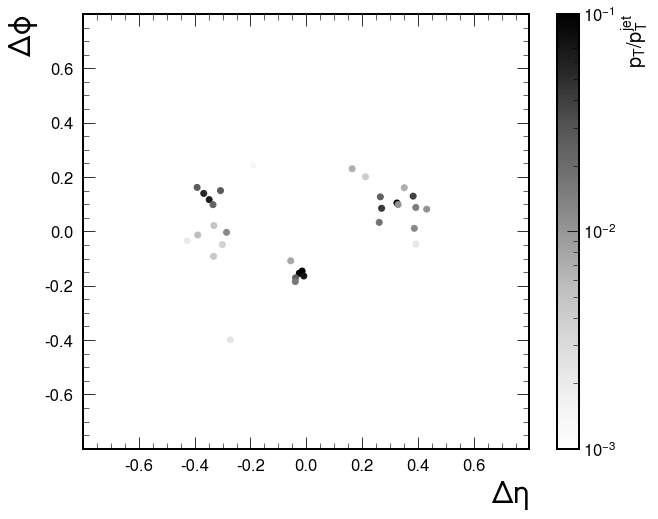

In [7]:
Num_jets = len(batch_px_list)
for i in range(Num_jets):

    if i != 27:
        continue        

    jet_label = batch_y_list[i]
    if jet_label!=1: # pick Tops for plotting
        continue
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    print(i, [(subjet_idx==0).sum(), (subjet_idx==1).sum(), (subjet_idx==2).sum()])

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    ax.scatter(
        eta,
        phi,
        c=pt,
        cmap='Greys',
        norm=colors.LogNorm(vmin=0.001, vmax=0.1),
    )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    ax.legend()    

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6]) 
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
#     plt.legend(title="Top jet" if jet_label==1 else "QCD jet", title_fontsize=40, fontsize=20)
    plt.legend(fontsize=23)    
    plt.savefig(f"/xai4hepvol/LRP/paper_plots/no_subjets_jet.pdf")    
    plt.show() 

## No edges

27 [8, 15, 13]
Building the graph...
Plotting the point cloud...


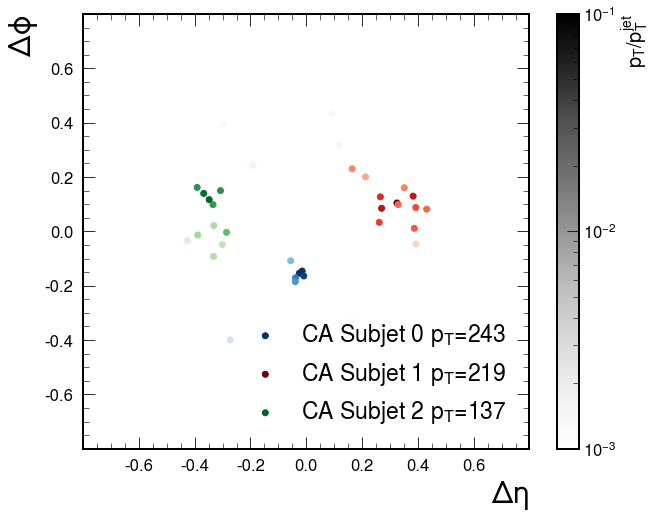

In [14]:
Num_jets = len(batch_px_list)
for i in range(Num_jets):

    if i != 27:
        continue        

    jet_label = batch_y_list[i]
    if jet_label!=1: # pick Tops for plotting
        continue
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    print(i, [(subjet_idx==0).sum(), (subjet_idx==1).sum(), (subjet_idx==2).sum()])

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Oranges', 'Yellows', 'Purples']

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets] 
    
    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    for j in range(Num_subjets):
        ax.scatter(
            eta[subjet_idx == j],
            phi[subjet_idx == j],
            c=pt[subjet_idx == j],
            cmap=COLOR_from_idx[j],
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    ax.legend()    

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 

    plt.ylim(-0.8, 0.8)
    plt.xlim(-0.8, 0.8)
    ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])    
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
#     plt.legend(title="Top jet" if jet_label==1 else "QCD jet", title_fontsize=40, fontsize=20)
    plt.legend(fontsize=23)    
    plt.savefig(f"/xai4hepvol/LRP/paper_plots/jet.pdf")    
    plt.show() 

## Edges

----------------------------
10
Building the graph...
Plotting the Edge-Rgraph for edge_conv_0...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


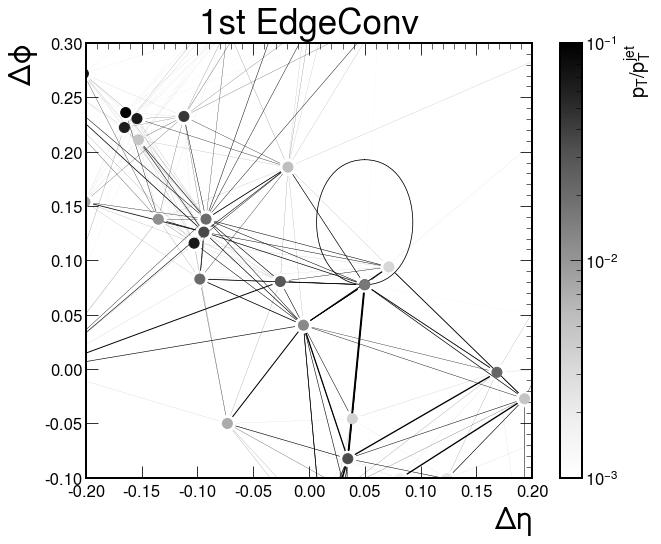

In [31]:
dic = {}
dic['edge_conv_0'] = '1st EdgeConv'
dic['edge_conv_1'] = '2nd EdgeConv'
dic['edge_conv_2'] = '3rd EdgeConv'

Num_jets = len(batch_px_list)
for i in range(Num_jets):

#     if i != 27:
#         continue        
#     if i not in [3, 2, 10, 11, 12, 14, 15, 20, 22, 23]:
    if i not in [10]:        
        continue
    jet_label = batch_y_list[i]
    if jet_label!=1: # pick Tops for plotting
        continue
    
    print("----------------------------")
    print(i)
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    eta, phi, pt = get_eta_phi_pt(px, py, pz, e)

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]
  
    # plot edgeconv blocks
#     for edgeconv in ['edge_conv_2', 'edge_conv_1', 'edge_conv_0']:    
#     for edgeconv in ['edge_conv_2']:    
    for edgeconv in ['edge_conv_0']:    

        edge_index, edge_weight = edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1)
        edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

        data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
        G = torch_geometric.utils.to_networkx(data, to_undirected=False)
        G.remove_edges_from(nx.selfloop_edges(G))
        
        print(f'Plotting the Edge-Rgraph for {edgeconv}...')        
        fig, ax = plt.subplots(figsize=(10, 8))
        draw_networkx_nodes(G, pos, 
                            node_color=np.log(pt),
                            node_size=100,
                            cmap='Greys', 
                            ax=ax, 
                           )            
        plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
        cbar = plt.colorbar()
        cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")

        draw_networkx_edges(G, pos, 
                            width=100*(edge_Rscores),
                            edge_color='k', 
                            style='solid', 
                            arrowsize=10,
                            ax=ax, 
                            arrowstyle='-'
                           )

        ax.legend()    
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

        plt.xlabel(r"$\Delta\eta$", fontsize=30) 
        plt.ylabel(r"$\Delta\phi$", fontsize=30) 
        
        plt.ylim(-0.1, 0.3)
        plt.xlim(-0.2, 0.2)
#         ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
#         ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])  
    #     plt.legend(title="Top jet" if jet_label==1 else "QCD jet")        
        plt.legend(fontsize=23)    
        ax.set_title(f"{dic[edgeconv]}", pad=10, fontsize=35) 
        plt.savefig(f"/xai4hepvol/LRP/paper_plots/no_subjets_{edgeconv}.pdf")
        plt.show()

In [53]:
list(G.edges)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 13),
 (0, 18),
 (0, 27),
 (0, 31),
 (0, 38),
 (0, 43),
 (0, 44),
 (0, 47),
 (0, 53),
 (0, 60),
 (1, 0),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 13),
 (1, 31),
 (1, 38),
 (1, 43),
 (1, 44),
 (1, 53),
 (1, 60),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (2, 11),
 (2, 12),
 (2, 17),
 (2, 18),
 (2, 23),
 (2, 26),
 (2, 27),
 (2, 31),
 (2, 33),
 (2, 40),
 (2, 43),
 (2, 51),
 (2, 59),
 (2, 60),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 5),
 (3, 7),
 (3, 9),
 (3, 13),
 (3, 18),
 (3, 27),
 (3, 31),
 (3, 38),
 (3, 43),
 (3, 44),
 (3, 47),
 (3, 53),
 (3, 59),
 (3, 60),
 (4, 10),
 (4, 15),
 (4, 28),
 (4, 33),
 (4, 39),
 (4, 45),
 (4, 49),
 (4, 50),
 (4, 54),
 (4, 58),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 7),
 (5, 9),
 (5, 13),
 (5, 18),
 (5, 27),
 (5, 31),
 (5, 38),
 (5, 43),
 (5, 44),
 (5, 53),
 (5, 59),
 (5, 60),
 (6, 8),
 (6, 14),
 (6, 20),
 (6, 21),
 (6, 25),
 (6, 29),
 (6, 32),
 (6, 34),
 (6, 35),
 (6, 37),
 (6, 45),
 (6, 48),
 (6, 52),
 (6, 55),
 (6, 57

In [ ]:
def get_two_broken_indices(eta, phi):
    return a,b

In [57]:
eta_phi = torch.cat([eta, phi], axis=1)

In [103]:
eta_phi[eta_ind]

tensor([[-0.0165, -0.5535],
        [ 0.1235, -0.1010]])

In [106]:
eta_ind

(array([], dtype=int64),)

In [107]:
eta_phi

tensor([[-1.6426e-01,  2.3594e-01],
        [-2.0216e-01,  2.7179e-01],
        [-1.0298e-01,  1.1579e-01],
        [-1.5415e-01,  2.3038e-01],
        [ 1.0756e-02, -1.4325e-01],
        [-1.6548e-01,  2.2219e-01],
        [ 2.6289e-02, -4.7483e-01],
        [-1.1210e-01,  2.3241e-01],
        [ 6.2470e-02, -5.6200e-01],
        [-9.4279e-02,  1.2600e-01],
        [ 3.4764e-02, -8.2410e-02],
        [-2.5722e-02,  8.0561e-02],
        [ 4.9878e-02,  7.7620e-02],
        [-7.3072e-02,  3.1402e-01],
        [ 1.9400e-02, -5.4946e-01],
        [ 3.1705e-02, -1.0986e-01],
        [ 1.6839e-01, -2.9771e-03],
        [-9.7859e-02,  8.2792e-02],
        [-9.2300e-02,  1.3796e-01],
        [ 2.3602e-01, -3.2891e-01],
        [ 2.4373e-02, -5.1044e-01],
        [ 3.3884e-02, -5.5583e-01],
        [ 2.8129e-01, -3.9461e-01],
        [ 4.9878e-02,  7.7620e-02],
        [ 3.2508e-01, -3.1531e-01],
        [ 9.5920e-02, -5.6009e-01],
        [-5.0426e-03,  4.0382e-02],
        [-1.3506e-01,  1.378

In [109]:
_, ind = np.unique(eta_phi, axis=0, return_counts=True)
ind

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [110]:
eta_phi[ind==2]

IndexError: The shape of the mask [62] at index 0 does not match the shape of the indexed tensor [64, 2] at index 0

In [112]:
ind.shape

(62,)

In [113]:
eta_phi.shape

torch.Size([64, 2])

In [94]:
_, ind = np.unique(eta, return_counts=True)
eta_ind = np.where(ind != 1)

_, ind = np.unique(phi, return_counts=True)
phi_ind = np.where(ind != 1)

In [95]:
eta_ind

(array([37, 50]),)

In [96]:
phi_ind

(array([16, 28, 38]),)

In [97]:
ind

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [90]:
dup

array([0.04987788, 0.17207122], dtype=float32)

In [70]:
val, ind = np.unique(phi, return_index=True)

In [72]:
ind

array([61, 55, 29, 34,  8, 25, 21, 37, 14, 35, 20,  6, 32, 57, 62, 22, 48,
       30, 19, 24, 45, 41, 28, 46, 39,  4, 36, 15, 50, 58, 10, 33, 49, 42,
       16, 59, 56, 26, 12, 11, 17, 51,  2,  9, 27, 18, 31, 40, 43,  5,  3,
        7,  0,  1, 60, 13, 38, 47, 63, 53, 44])

In [ ]:
def from_edges_remove_duplicates(G, a, b):
    
    for tuple_ in list(G.edges):
        if (tuple_[0]==a) and (if tuple[1]==b):
            G.remove_edge(tuple_)
            

In [54]:
eta

tensor([[-0.1643],
        [-0.2022],
        [-0.1030],
        [-0.1542],
        [ 0.0108],
        [-0.1655],
        [ 0.0263],
        [-0.1121],
        [ 0.0625],
        [-0.0943],
        [ 0.0348],
        [-0.0257],
        [ 0.0499],
        [-0.0731],
        [ 0.0194],
        [ 0.0317],
        [ 0.1684],
        [-0.0979],
        [-0.0923],
        [ 0.2360],
        [ 0.0244],
        [ 0.0339],
        [ 0.2813],
        [ 0.0499],
        [ 0.3251],
        [ 0.0959],
        [-0.0050],
        [-0.1351],
        [ 0.0344],
        [ 0.0025],
        [ 0.2634],
        [-0.2008],
        [ 0.1459],
        [-0.0732],
        [ 0.1222],
        [-0.0021],
        [ 0.3847],
        [-0.0165],
        [ 0.0009],
        [ 0.0125],
        [-0.0189],
        [ 0.2161],
        [ 0.1931],
        [-0.1529],
        [ 0.0606],
        [-0.0575],
        [ 0.1927],
        [ 0.0624],
        [ 0.1721],
        [ 0.0388],
        [ 0.1235],
        [ 0.0716],
        [ 0.

In [45]:
phi.shape

torch.Size([64, 1])

In [47]:
pt.to_numpy().reshape(-1,1)

array([[0.11355932],
       [0.0827696 ],
       [0.07306478],
       [0.07073521],
       [0.07034907],
       [0.0652579 ],
       [0.05207275],
       [0.04326484],
       [0.03373904],
       [0.03220616],
       [0.03107433],
       [0.02453529],
       [0.02422373],
       [0.02355643],
       [0.02255367],
       [0.01900719],
       [0.018335  ],
       [0.01692609],
       [0.01675785],
       [0.01580538],
       [0.01500111],
       [0.01435487],
       [0.01347657],
       [0.01279246],
       [0.01224567],
       [0.01027272],
       [0.00865937],
       [0.00806289],
       [0.00688436],
       [0.00681806],
       [0.00559571],
       [0.00524951],
       [0.00479493],
       [0.00474537],
       [0.00459093],
       [0.00414245],
       [0.0040704 ],
       [0.00363961],
       [0.00360229],
       [0.00343116],
       [0.00324009],
       [0.00296537],
       [0.00285539],
       [0.00280742],
       [0.00257036],
       [0.00255299],
       [0.00233623],
       [0.002

## Edges with subjets

27 [8, 15, 13]
Building the graph...
Plotting the Edge-Rgraph for edge_conv_2...


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


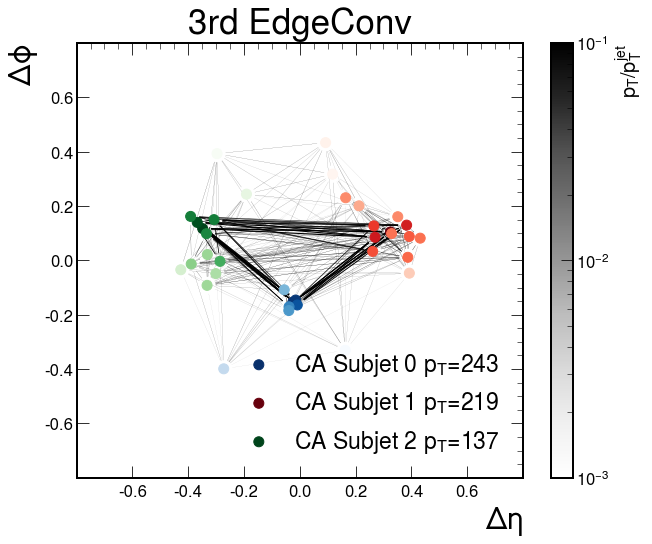

Plotting the Edge-Rgraph for edge_conv_1...


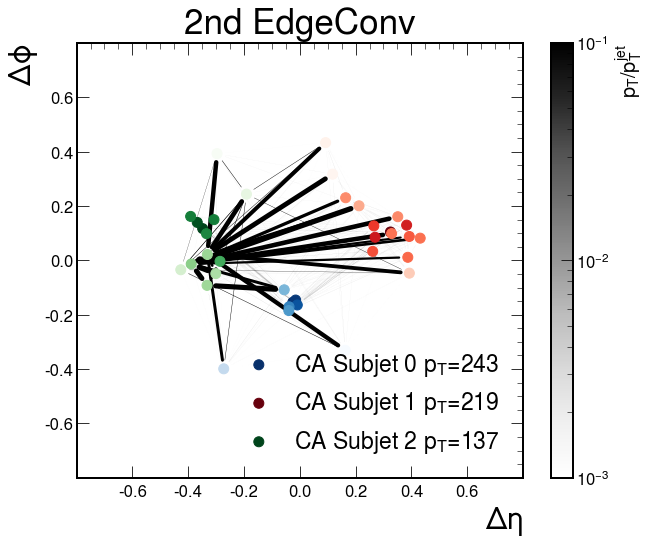

Plotting the Edge-Rgraph for edge_conv_0...


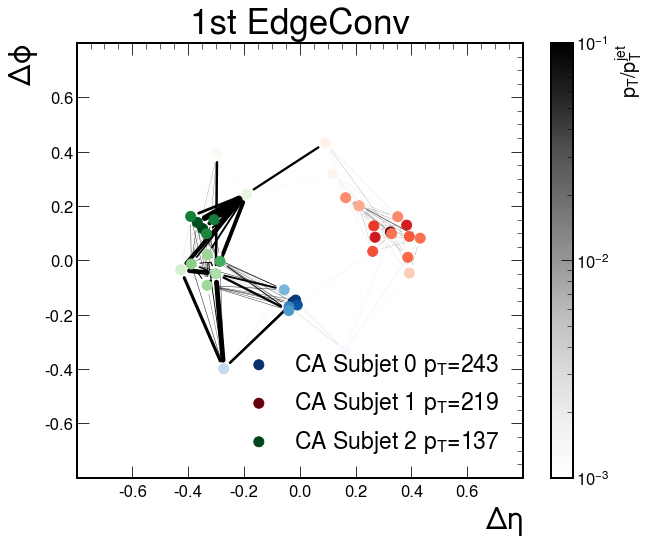

In [16]:
dic = {}
dic['edge_conv_0'] = '1st EdgeConv'
dic['edge_conv_1'] = '2nd EdgeConv'
dic['edge_conv_2'] = '3rd EdgeConv'

Num_jets = len(batch_px_list)
for i in range(Num_jets):

    if i != 27:
        continue        

    jet_label = batch_y_list[i]
    if jet_label!=1: # pick Tops for plotting
        continue
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    print(i, [(subjet_idx==0).sum(), (subjet_idx==1).sum(), (subjet_idx==2).sum()])

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Oranges', 'Yellows', 'Purples']

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets]   
            
    # plot edgeconv blocks
    for edgeconv in ['edge_conv_2', 'edge_conv_1', 'edge_conv_0']:    

        edge_index, edge_weight = edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1)
        edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

        data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
        G = torch_geometric.utils.to_networkx(data, to_undirected=False)

        print(f'Plotting the Edge-Rgraph for {edgeconv}...')        
        fig, ax = plt.subplots(figsize=(10, 8))
        for j in range(Num_subjets):
            
            draw_networkx_nodes(G, pos, 
                                nodelist=np.array(list(G))[subjet_idx==j].tolist(), 
                                node_color=np.log(pt[subjet_idx==j]),
                                node_size=100,
                                cmap=COLOR_from_idx[j], 
                                ax=ax, 
                                label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",                        
                               )
        plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
        cbar = plt.colorbar()
        cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")

        draw_networkx_edges(G, pos, 
                            width=100*(edge_Rscores),
                            edge_color='k', 
                            style='solid', 
                            arrowsize=10,
                            ax=ax, 
                            arrowstyle='-'
                           )

        ax.legend()    
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

        plt.xlabel(r"$\Delta\eta$", fontsize=30) 
        plt.ylabel(r"$\Delta\phi$", fontsize=30) 
        
        plt.ylim(-0.8, 0.8)
        plt.xlim(-0.8, 0.8)
        ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
        ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    #     plt.legend(title="Top jet" if jet_label==1 else "QCD jet")        
        plt.legend(fontsize=23)    
        ax.set_title(f"{dic[edgeconv]}", pad=10, fontsize=35) 
        plt.savefig(f"/xai4hepvol/LRP/paper_plots/{edgeconv}.pdf")
        plt.show()        

# Scaling up

In [46]:
def scaling_up(trained=True, Top_N=15):

    top_same = np.array([0] * Top_N)
    top_diff = np.array([0] * Top_N)
    qcd_same = np.array([0] * Top_N)
    qcd_diff = np.array([0] * Top_N)

    if trained:
        loops = 1    
    else:
        loops = 10
        
    for loop, models in enumerate(range(loops)):

        if trained:
            PATH = f"/xai4hepvol/LRP/{model_prefix}/Rscores_best_10k"
        else:
            PATH = f"/xai4hepvol/LRP/{model_prefix}/Rscores_{loop}"

        with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
            batch_x_list = pkl.load(handle)
        with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
            batch_y_list = pkl.load(handle)    
        with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
            R_edges_list = pkl.load(handle)    
        with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
            edge_index_list = pkl.load(handle)

        with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
            batch_px_list = pkl.load(handle)
        with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
            batch_py_list = pkl.load(handle)  
        with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
            batch_pz_list = pkl.load(handle)
        with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
            batch_E_list = pkl.load(handle)  

        Num_jets = len(batch_px_list)
        for i in tqdm(range(Num_jets)):
            jet_label = batch_y_list[i]

            R_edges = R_edges_list[i]
            edge_index_dic = edge_index_list[i]

            px = batch_px_list[i]
            py = batch_py_list[i]
            pz = batch_pz_list[i]
            e = batch_E_list[i]

            # get subjets
            try:
                subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
            except:
                print(f"skipping jet # {i}")
                continue

            # top N edges
            edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
            edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

            for N in range(Top_N):
                for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
                    if jet_label==1:
                        if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                            top_diff[N] += 1
                        else:
                            top_same[N] += 1
                    else:
                        if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                            qcd_diff[N] += 1
                        else:
                            qcd_same[N] += 1

                            
    top_fraction = top_diff/(top_same+top_diff)
    qcd_fraction = qcd_diff/(qcd_same+qcd_diff)
    
    if trained:
        name = 'trained'
    else:
        name = 'untrained'
        
    with open(f"/xai4hepvol/LRP/{model_prefix}/{name}_top_fraction.pkl", 'wb') as f:
        pkl.dump(top_fraction, f)
    with open(f"/xai4hepvol/LRP/{model_prefix}/{name}_qcd_fraction.pkl", 'wb') as f:
        pkl.dump(qcd_fraction, f)  
    
    return top_fraction, qcd_fraction

In [ ]:
# trained model
trained_top_fraction, trained_qcd_fraction = scaling_up(trained=True)

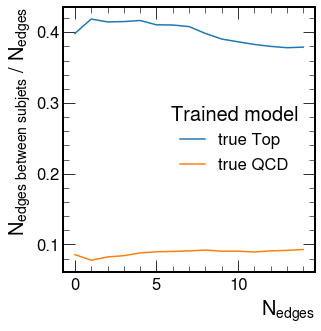

In [19]:
# load and plot
with open(f"/xai4hepvol/LRP/{model_prefix}/trained_top_fraction.pkl", 'rb') as f:
    trained_top_fraction = pkl.load(f) 
with open(f"/xai4hepvol/LRP/{model_prefix}/trained_qcd_fraction.pkl", 'rb') as f:
    trained_qcd_fraction = pkl.load(f) 
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(trained_top_fraction)), trained_top_fraction, label='true Top')
ax.plot(range(len(trained_qcd_fraction)), trained_qcd_fraction, label='true QCD')

ax.legend(title='Trained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)
fig.tight_layout()
plt.show()

In [ ]:
# untrained model
untrained_top_fraction, untrained_qcd_fraction = scaling_up(trained=False)

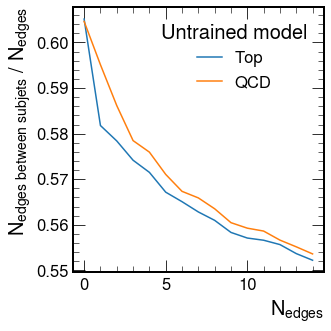

In [20]:
# load and plot
with open(f"/xai4hepvol/LRP/{model_prefix}/untrained_top_fraction.pkl", 'rb') as f:
    untrained_top_fraction = pkl.load(f) 
with open(f"/xai4hepvol/LRP/{model_prefix}/untrained_qcd_fraction.pkl", 'rb') as f:
    untrained_qcd_fraction = pkl.load(f) 
    
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(len(untrained_top_fraction)), untrained_top_fraction, label='Top')
ax.plot(range(len(untrained_qcd_fraction)), untrained_qcd_fraction, label='QCD')
ax.legend(title='Untrained model')
ax.set_xlabel(r'$N_{edges}$', fontsize=20)
ax.set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)
fig.tight_layout()
plt.show()

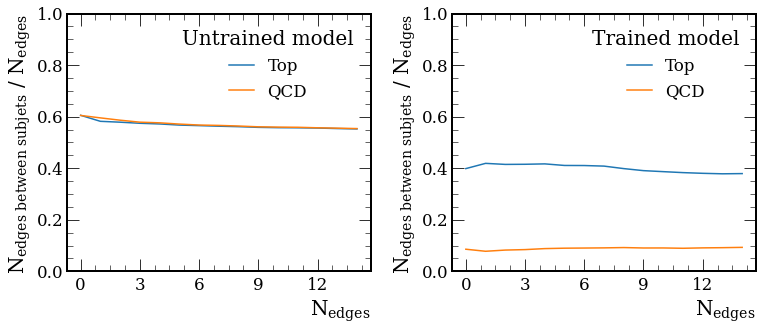

In [21]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_name('Times New Roman')
plt.rcParams.update({'font.family':'serif'}) 

fig, axes = plt.subplots(ncols=2, figsize=(11,5))
axes[0].plot(range(len(untrained_top_fraction)), untrained_top_fraction, label='Top')
axes[0].plot(range(len(untrained_qcd_fraction)), untrained_qcd_fraction, label='QCD')
axes[0].legend(title='Untrained model')
axes[0].set_xticks(range(0, 15, 3))
axes[0].set_xlabel(r'$N_{edges}$', fontsize=20)
axes[0].set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)
axes[0].set_ylim(0,1)
# axes[0].set_yscale('log') 

axes[1].plot(range(len(trained_top_fraction)), trained_top_fraction, label='Top')
axes[1].plot(range(len(trained_qcd_fraction)), trained_qcd_fraction, label='QCD')
axes[1].legend(title='Trained model')
axes[1].set_xticks(range(0, 15, 3))
axes[1].set_xlabel(r'$N_{edges}$', fontsize=20)
axes[1].set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)
axes[1].set_ylim(0,1)
# axes[0].set_yscale('log') 

fig.tight_layout()

plt.savefig('/xai4hepvol/LRP/paper_plots/scaling_up.pdf')
plt.show()

## CA bar plot

In [26]:
from tqdm.notebook import tqdm

top = np.array([0] * 3)
qcd = np.array([0] * 3)
    
Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue
  
    if jet_label==1:
        top[0] += (subjet_idx == 0).sum()
        top[1] += (subjet_idx == 1).sum()
        top[2] += (subjet_idx == 2).sum()
    else:
        qcd[0] += (subjet_idx == 0).sum()
        qcd[1] += (subjet_idx == 1).sum()
        qcd[2] += (subjet_idx == 2).sum()

  0%|          | 0/996 [00:00<?, ?it/s]

skipping jet # 25
skipping jet # 537


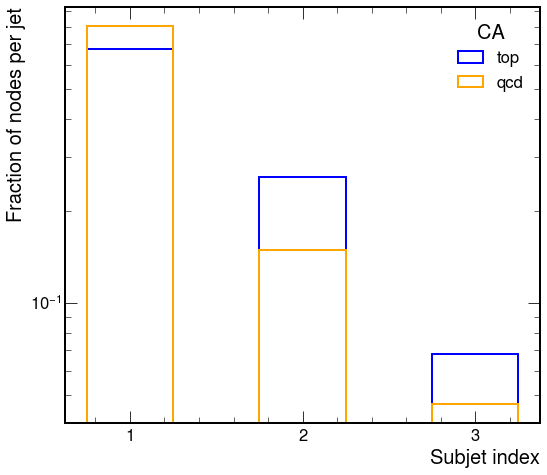

In [76]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.bar([0.2,0.3,0.4], top/top.sum(), width=0.05, linewidth=2, edgecolor='Blue', fill=False, align='center', label='top', tick_label=[1,2,3])
ax.bar([0.2,0.3,0.4], qcd/qcd.sum(), width=0.05, linewidth=2, edgecolor='Orange', fill=False, align='center', label='qcd', tick_label=[1,2,3])

ax.legend()

plt.legend(title=f"{LABEL[JET_ALGO]}")
    
ax.set_yscale('log')
ax.set_xlabel(r"Subjet index")
ax.set_ylabel(r"Fraction of nodes per jet")
plt.tight_layout()
plt.savefig(f"/xai4hepvol/LRP/paper_plots/CA_bar.pdf")